In [99]:
import sklearn
import xgboost as xgb
import catboost
import lightgbm as lgb
import tsfresh
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import seaborn as sea
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold


In [58]:
##Import and format the data
df = pd.read_csv('train_small.csv',header = None, index_col=0)
dt = pd.read_csv('test_small.csv', index_col=0)

newcolnames = ["var_{}".format(i) for i in range(200)]
newcolnames.insert(0,"target")

df.columns = newcolnames

#Show the data
df.head(5)

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,,,,,,,,,,,,,,,,,,,,,
train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
train_5,0,11.4763,-2.3182,12.6080,8.6264,10.9621,3.5609,4.5322,15.2255,3.5855,...,-6.3068,6.6025,5.2912,0.4403,14.9452,1.0314,-3.6241,9.7670,12.5809,-4.7602
train_6,0,11.8091,-0.0832,9.3494,4.2916,11.1355,-8.0198,6.1961,12.0771,-4.3781,...,8.7830,6.4521,3.5325,0.1777,18.3314,0.5845,9.1104,9.1143,10.8869,-3.2097


In [65]:
#The target mean tells us the ratio between the target, meaning that about 10% are 1 and about 90% 0.
#The target values are quite unbalanced. A lot of values seem quite varying for the features and the standard deviation
#seems rather high compared to the mean in many of the features

#This suggests that the data is quite varying
df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,...,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000,70057.000000
mean,0.099733,10.678757,-1.625370,10.718501,6.801363,11.080280,-5.099666,5.412131,16.557562,0.284365,...,3.257023,7.444208,1.927193,3.328773,18.008622,-0.140578,2.298631,8.906114,15.869843,-3.323176
std,0.299646,3.037911,4.060012,2.629766,2.043351,1.627265,7.887190,0.867160,3.422813,3.335973,...,4.540336,3.018182,1.481911,3.988392,3.138089,1.427751,5.460012,0.920043,3.014017,10.438217
min,0.000000,0.597900,-15.043400,2.615000,-0.040200,5.490200,-29.777300,2.347300,5.349700,-9.905100,...,-13.999500,-2.009400,-3.566800,-11.783400,9.594900,-4.644200,-14.020400,5.960600,6.299300,-38.852800
25%,0.000000,8.461000,-4.751700,8.742600,5.252000,9.877400,-11.271800,4.768100,13.951300,-2.335100,...,-0.022800,5.161900,0.886300,0.587800,15.640500,-1.164000,-1.956100,8.253600,13.819700,-11.236200
50%,0.000000,10.526500,-1.614100,10.589100,6.837700,11.113000,-4.844100,5.387400,16.464600,0.409100,...,3.231400,7.341700,1.899100,3.387100,17.975900,-0.169000,2.390700,8.886000,15.931700,-2.800100
75%,0.000000,12.749600,1.371600,12.505900,8.333400,12.268000,0.907600,6.005500,19.119800,2.946300,...,6.410200,9.529300,2.952300,6.206400,20.421000,0.828300,6.573400,9.589400,18.071500,4.855300
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,16.806500,8.447700,27.638900,9.482200,...,18.342300,16.684600,7.611600,17.908600,27.928800,4.075600,16.226600,11.843900,26.079100,27.531900


In [66]:
#Lets describe the test set and see if values are similar.
#We see similarities in the means, as one would expect. Additionally there are similarities in some of the other values
dt.describe()

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,...,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000,70065.000000
mean,10.673473,-1.636284,10.716429,6.789705,11.075697,-5.040173,5.406073,16.531615,0.287496,7.561346,...,3.192914,7.434805,1.929542,3.306963,17.985451,-0.144594,2.292337,8.913608,15.875528,-3.363418
std,3.038395,4.043325,2.645041,2.042268,1.622335,7.864192,0.867739,3.413390,3.329416,1.238668,...,4.566389,3.025254,1.478161,3.985700,3.144663,1.426939,5.442084,0.922834,3.013491,10.458007
min,0.452800,-14.696200,2.117100,0.255000,5.074800,-32.562600,2.495700,6.465300,-10.505500,4.177100,...,-13.454700,-2.343000,-3.814500,-10.828300,8.694400,-5.018500,-13.885900,6.143200,6.644800,-38.852800
25%,8.443200,-4.745900,8.718200,5.250600,9.886400,-11.161400,4.764700,13.933300,-2.306100,6.604600,...,-0.096300,5.153000,0.895000,0.563300,15.613300,-1.173900,-1.953300,8.255200,13.835100,-11.227900
50%,10.510400,-1.613400,10.580600,6.816300,11.108100,-4.820800,5.381800,16.435100,0.395100,7.619900,...,3.168000,7.346800,1.899700,3.379800,17.937000,-0.176100,2.390600,8.890100,15.950100,-2.871800
75%,12.767100,1.324400,12.523700,8.306400,12.255000,0.948800,6.003600,19.093000,2.932600,8.579700,...,6.360100,9.500200,2.951800,6.179200,20.399200,0.827700,6.524600,9.600300,18.070600,4.831400
max,19.998400,10.167100,18.412700,13.098300,15.991400,17.128100,8.285200,27.691800,10.151300,11.150600,...,18.431800,16.541100,8.402400,18.281800,27.597300,4.255700,17.684100,11.851100,26.034600,28.500700


In [68]:
#Lets see if we're missing values
df.isnull().any().any()

False

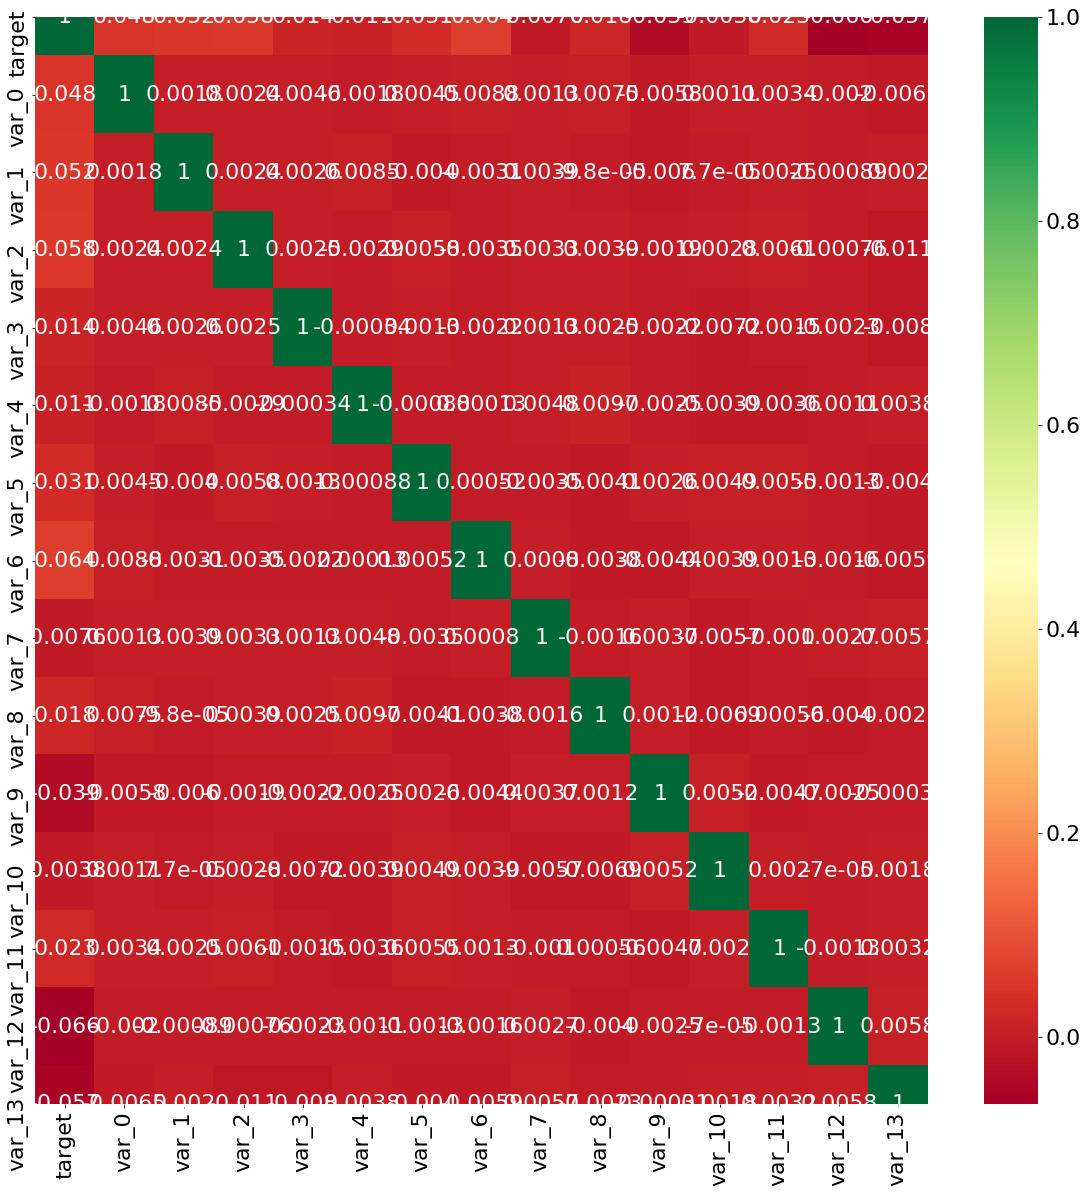

In [57]:
#Lets look at the correlation matrix of the first 15 features (This was done for all, not just the first 15).

newdf = df.iloc[:,:15]
corrmat = newdf.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#Plotting the heat map
g=sea.heatmap(newdf[top_corr_features].corr(),annot=True,cmap="RdYlGn")

#The graph shows us that in the first 15 variables there is little to no correlation between them.
#However, we can see that there is some varying correlation to target. We investigate this correlation further.
#This was plotted for more than just the first 15 as well to confirm.

In [46]:
#We check the correlations in values between the features to the target
#Later we graph them and show them visually
correlations = df.corr()

#Take the absolute value and sort them descending
correlations['target'] = correlations['target'].abs()
corrlist = correlations["target"].sort_values(ascending = False)
corrlist

target     1.000000
var_81     0.080997
var_139    0.070490
var_53     0.068790
var_12     0.066019
             ...   
var_160    0.001560
var_126    0.000945
var_30     0.000866
var_185    0.000648
var_39     0.000176
Name: target, Length: 201, dtype: float64

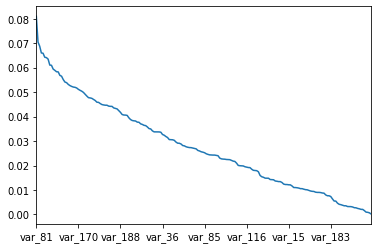

In [49]:
#The slope of the sorted variables by correlation to the target
#While we in the feature engineering will probably drop some less correlated features, there does not seem to be a clear-cut
#line in which we should separate the features
corrlist.drop("target").plot()

<Figure size 1080x720 with 0 Axes>

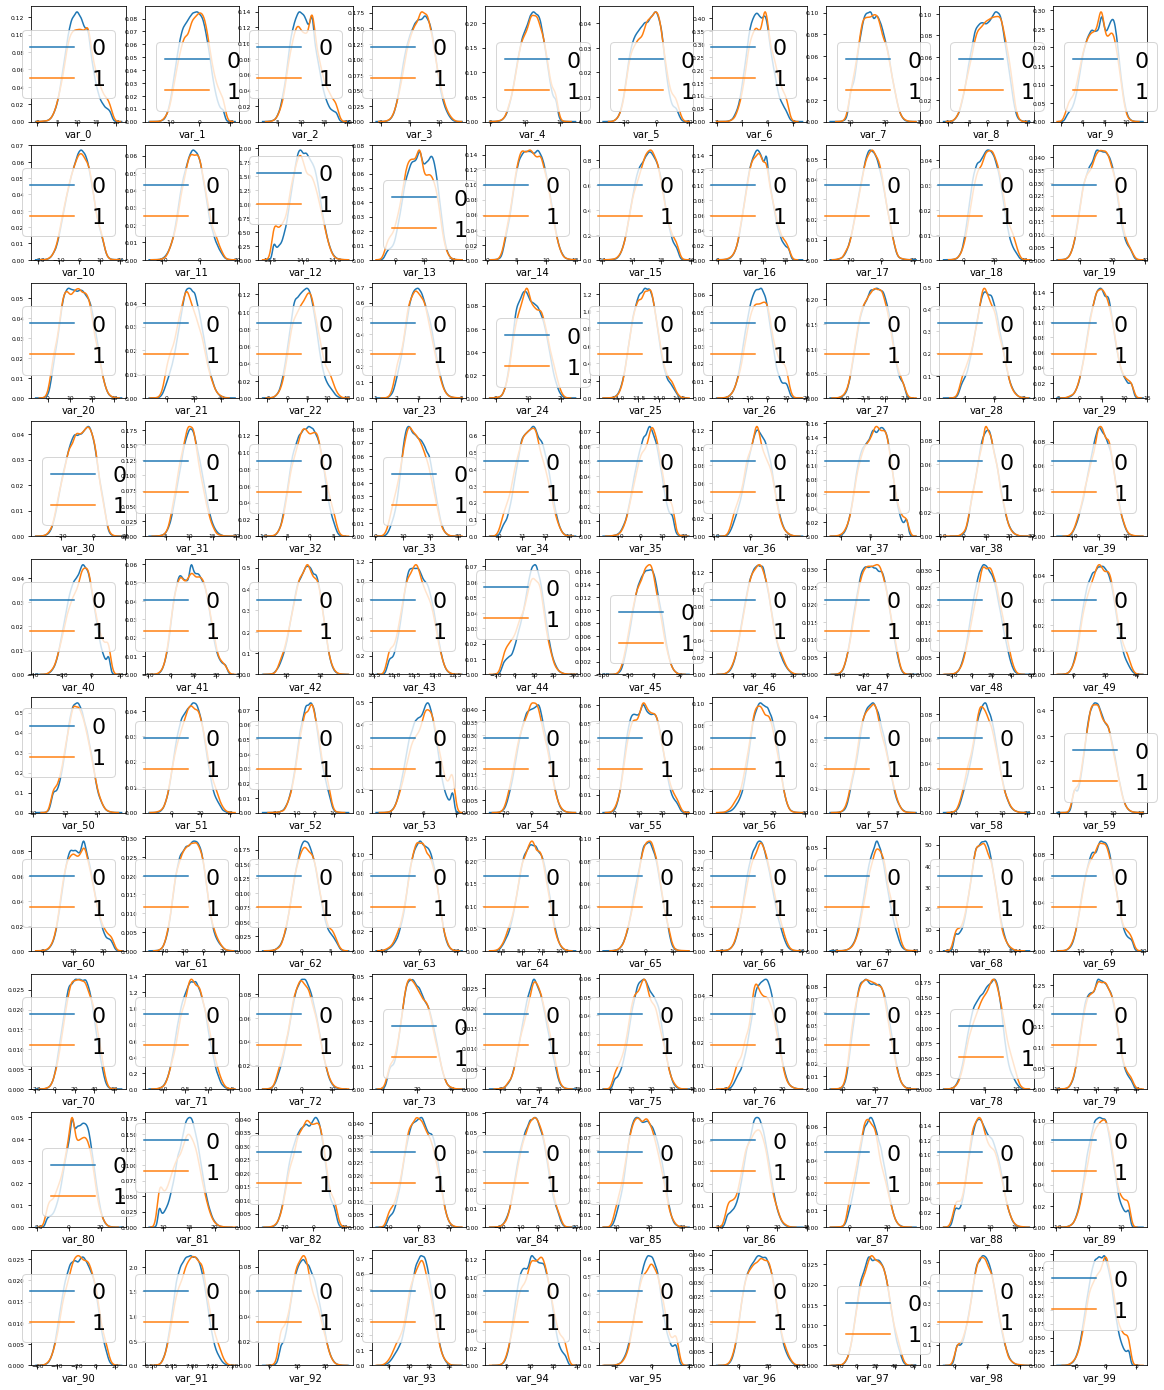

In [67]:
#Lets plot all of the distributions for the features to the targets and see if it matches our correlation beliefs.
#I only plotted the first 100 in this example and the next 100 was also plotted.
#As you can see, there's high variance in our top expected features var_81, var_53 and var_12.
#And very low variance in our bottom ones var_39 and var_30.
#This was also the case for the remaining 100 in that plot 

#Later on when we add kfolds and all that we can revisit the correlations to target.
plt.figure()
fig, ax = plt.subplots(10,10, figsize=(20,25))

feats = df.columns.values[1:101]
i = 0
for feat in feats:
    i += 1
    plt.subplot(10,10,i)
    sea.distplot(X0[feat],hist = False, label='0')
    sea.distplot(X1[feat],hist = False, label='1')
    plt.xlabel(feat, fontsize = 10)
    locs, labels = plt.xticks()
    plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
    plt.tick_params(axis='y', which='major', labelsize=6)
plt.show()

In [4]:
#Separated the 1s and 0s to find ratio and to review the differences. In case needed
X0 = df.loc[ df["target"] == 0]
X1 = df.loc[ df["target"] == 1]
X = df.drop("target", 1)
y = df["target"]

In [95]:
label = df.target
features = [c for c in df.columns if c not in ['ID_code','target']]

X_train, X_test, y_train, y_test = train_test_split(df[features], label, test_size = 0.02, random_state = 7)
X_train1, y_train1 = X_train, y_train
X_test1, y_test1 = X_test, y_test

model1 = RandomForestClassifier(n_estimators = 50, random_state = 0).fit(X_train1, y_train1)
y_pred = model1.predict(X_test1)

from sklearn.metrics import accuracy_score,roc_curve, auc
accuracy_score(y_test1, y_pred)
print("CV score: {:<8.5f}".format(roc_auc_score(y_test1, y_pred)))

CV score: 0.50000 


In [96]:
features = [c for c in df.columns if c not in ['ID_code', 'target']]


#A lot of the fine tuning of these parameters were done with the help of this blogpost:
# https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc
param = {
    #Lets use bagging to speed up the training and avoid overfitting.
    #Saw a better performance reducing the bagging frac to 0.5
    'bagging_freq': 5,
    'bagging_fraction': 0.5,
    'feature_fraction': 0.05,
    
    #Kept learning rate at default
    'learning_rate': 0.01,
    
    #Kept max depth at default
    'max_depth': -1,  
    
    #Saw an increase in increasing from the default (20) in min data in leaf
    #Increasing the min sum hessian in leaf also increased performance
    #These both deal with over-fitting
    'min_data_in_leaf': 100,
    'min_sum_hessian_in_leaf': 10.0,
    #Saw a performance increase when reducing number of leaves from default (31)
    'num_leaves': 10,
    #Set it to my number of CPU cores
    'num_threads': 4,
    
    #Defined the other needed params
    'objective': 'binary', 
    'tree_learner': 'serial',
    'boost_from_average':'false',
    'boost': 'gbdt',
    #We are measuring with the auc metric
    'metric':'auc',
}

In [97]:
features

['var_0',
 'var_1',
 'var_2',
 'var_3',
 'var_4',
 'var_5',
 'var_6',
 'var_7',
 'var_8',
 'var_9',
 'var_10',
 'var_11',
 'var_12',
 'var_13',
 'var_14',
 'var_15',
 'var_16',
 'var_17',
 'var_18',
 'var_19',
 'var_20',
 'var_21',
 'var_22',
 'var_23',
 'var_24',
 'var_25',
 'var_26',
 'var_27',
 'var_28',
 'var_29',
 'var_30',
 'var_31',
 'var_32',
 'var_33',
 'var_34',
 'var_35',
 'var_36',
 'var_37',
 'var_38',
 'var_39',
 'var_40',
 'var_41',
 'var_42',
 'var_43',
 'var_44',
 'var_45',
 'var_46',
 'var_47',
 'var_48',
 'var_49',
 'var_50',
 'var_51',
 'var_52',
 'var_53',
 'var_54',
 'var_55',
 'var_56',
 'var_57',
 'var_58',
 'var_59',
 'var_60',
 'var_61',
 'var_62',
 'var_63',
 'var_64',
 'var_65',
 'var_66',
 'var_67',
 'var_68',
 'var_69',
 'var_70',
 'var_71',
 'var_72',
 'var_73',
 'var_74',
 'var_75',
 'var_76',
 'var_77',
 'var_78',
 'var_79',
 'var_80',
 'var_81',
 'var_82',
 'var_83',
 'var_84',
 'var_85',
 'var_86',
 'var_87',
 'var_88',
 'var_89',
 'var_90',
 'var_91'

In [100]:
#Parts of my model was inspired by a previous Kaggle post on a problem about Home Credit Default Risk
#It can be found here: https://www.kaggle.com/sishihara/simple-lightgbm-kfold
#Model

#We use kfold
folds = KFold(n_splits=10, shuffle=False, random_state=0)
oof_preds = np.zeros(len(df))
sub_preds = np.zeros(len(dt))

#feature_importance_df = pd.DataFrame()
target = df['target']

for fold_, (trn_idx, val_idx) in enumerate(folds.split(df.values, target.values)):
    print("Running fold: {}".format(fold_))
    trn_data = lgb.Dataset(df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(df.iloc[val_idx][features], label=target.iloc[val_idx])

    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 3000)
    oof[val_idx] = clf.predict(df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    #feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(dt[features], num_iteration=clf.best_iteration) / folds.n_splits

print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))

Running fold: 0
Training until validation scores don't improve for 3000 rounds
[1000]	training's auc: 0.910578	valid_1's auc: 0.878828
[2000]	training's auc: 0.92583	valid_1's auc: 0.88613
[3000]	training's auc: 0.936575	valid_1's auc: 0.890783
[4000]	training's auc: 0.94481	valid_1's auc: 0.893065
[5000]	training's auc: 0.951753	valid_1's auc: 0.89496
[6000]	training's auc: 0.957884	valid_1's auc: 0.895394
[7000]	training's auc: 0.963191	valid_1's auc: 0.896181
[8000]	training's auc: 0.9681	valid_1's auc: 0.895975
[9000]	training's auc: 0.972438	valid_1's auc: 0.895827
[10000]	training's auc: 0.976372	valid_1's auc: 0.895628
Early stopping, best iteration is:
[7514]	training's auc: 0.965845	valid_1's auc: 0.896523
Running fold: 1
Training until validation scores don't improve for 3000 rounds
[1000]	training's auc: 0.911427	valid_1's auc: 0.875579
[2000]	training's auc: 0.926958	valid_1's auc: 0.884443
[3000]	training's auc: 0.93744	valid_1's auc: 0.887578
[4000]	training's auc: 0.9452

In [5]:
#Split the data with train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=50)

In [8]:
feats = df
plot_feature_scatter(train_df[::20], test_df[::20], feats)

NameError: name 'plot_feature_scatter' is not defined

In [ ]:
#

d_train = xgb.DMatrix(X_train, label = y_train, missing = -1)
d_test = xgb.DMatrix(X_test)

train_labels = d_train.get_label()
ratio = float(np.sum(train_labels == 0)) / np.sum(train_labels == 1)

params = {
    'objective': 'binary:logistic',
    'silent': 1,
    'eta': 0.3,
    'max_depth': 1,
    'scale_pos_weight': ratio,
    'subsample': 0.8,
    'learning_rate': 0.3,
    'colsample_bytree': 0.5,
    'gamma': 1
}
num_round = 81

In [ ]:
plt.matshow(df.corr())
plt.show()

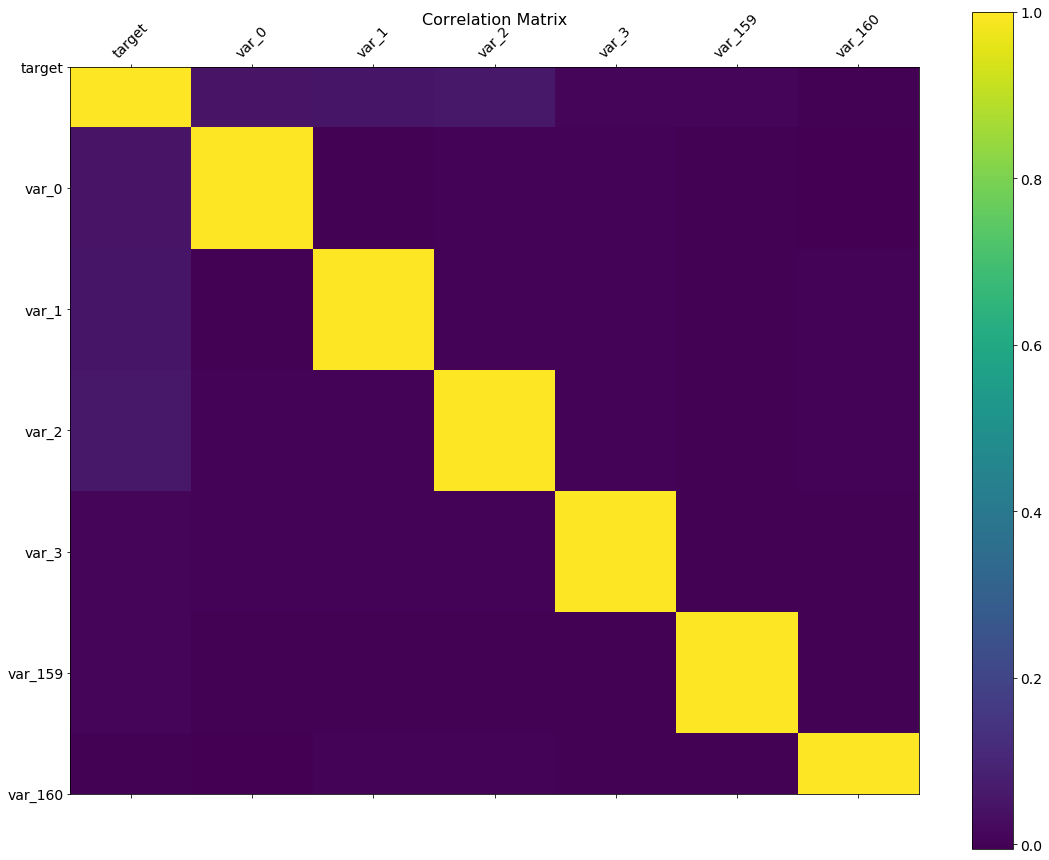

In [70]:

df2 = df[['target','var_0','var_1','var_2','var_3','var_159','var_160']]
f = plt.figure(figsize=(19, 15))
plt.matshow(df2.corr(), fignum=f.number)
plt.xticks(range(df2.shape[1]), df2.columns, fontsize=14, rotation=45)
plt.yticks(range(df2.shape[1]), df2.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

In [ ]:
df2 = (df[['var_1', 'var_139']])
plt.plot(df2.head(50))

In [ ]:
#noe
model = xgb.train(params,d_train,num_round)

#noe
preds = model.predict(d_test)

In [ ]:
from sklearn.decomposition import PCA

dpca = pd.DataFrame(data=np.random.normal(0, 1, (20, 10)))

pca = PCA(n_components=5)
pca.fit(df)

In [ ]:
pca.components_ 

In [50]:
%matplotlib inline
from matplotlib import pyplot
from matplotlib.pylab import rcParams
rcParams.update({'font.size': 22})
rcParams['figure.figsize'] = 15,10

xgb.plot_importance(model,max_num_features=15)
pyplot.show()

NameError: name 'model' is not defined